# Pré-processamento dos dados

In [1]:
# Importando as bibliotecas 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Carregando o arquivo 
# O dataset contém 43 colunas: 42 features + label
dataset = pd.read_csv("../Dados/method-level.csv")

textClassColumn = dataset["CLASS"].copy()

# Tratamento da label: No smell (0), AR (1), ET (2), CTL (3), VT (4) 
dataset['CLASS'] = dataset['CLASS'].replace('No',0)
dataset['CLASS'] = dataset['CLASS'].replace('AR',1)
dataset['CLASS'] = dataset['CLASS'].replace('ET',2)
dataset['CLASS'] = dataset['CLASS'].replace('CTL',3)
dataset['CLASS'] = dataset['CLASS'].replace('VT',4)

# Drop caminho do arquivo
dataset = dataset.drop(['Method'], axis=1)

In [3]:
# Descriptive statistics
dataset.describe()

,cbo,wmc,rfc,loc,variablesQty,methodsInvokedQty,methodsInvokedLocalQty,methodsInvokedIndirectLocalQty,stringLiteralsQty,numbersQty,assignmentsQty,maxNestedBlocksQty,uniqueWordsQty,CLASS
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,4.638723,1.656687,7.762475,15.011976,3.506986,7.762475,0.461078,0.538922,4.818363,2.778443,4.143713,0.481038,21.083832,2.019960
std,3.315301,1.364515,7.326764,13.503179,3.908766,7.326764,0.580502,0.751653,7.183380,5.445807,4.603836,0.752423,11.253842,1.416898
min,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,3.000000,1.000000,3.000000,6.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000,1.000000
50%,4.000000,1.000000,6.000000,9.000000,2.000000,6.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,20.000000,2.000000
75%,5.000000,2.000000,10.000000,21.000000,5.000000,10.000000,1.000000,1.000000,6.000000,3.000000,6.000000,1.000000,27.000000,3.000000
max,21.000000,13.000000,55.000000,68.000000,24.000000,55.000000,3.000000,6.000000,44.000000,67.000000,26.000000,5.000000,67.000000,4.000000


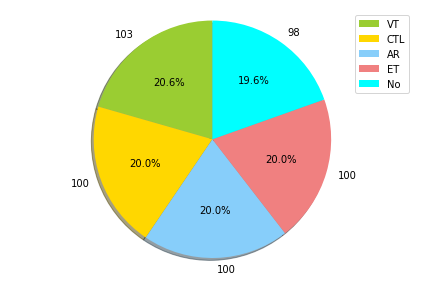

In [8]:
# Balanceamento da quantidade de instâncias em relação às classes
temp = textClassColumn.value_counts()
df = pd.DataFrame({'labels': temp.index,'values': temp.values})
labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan']
patches, texts, percTexts = plt.pie(sizes, colors=colors, labels=sizes , shadow=True, startangle=90, autopct='%1.1f%%')
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

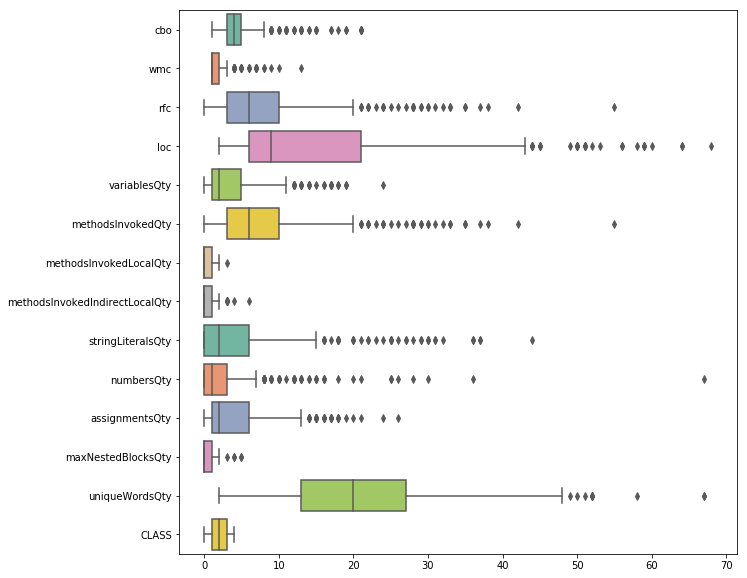

In [9]:
# Boxplot de todo o dataset
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.boxplot(data=dataset, orient="h", palette="Set2")

In [4]:
# Obtendo nome das colunas sem a coluna de rotulo
allColumnsWithoutLabel = dataset.columns[:-1]
allColumnsWithoutLabel

Index(['cbo', 'wmc', 'rfc', 'loc', 'variablesQty', 'methodsInvokedQty',
       'methodsInvokedLocalQty', 'methodsInvokedIndirectLocalQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'maxNestedBlocksQty', 'uniqueWordsQty'],
      dtype='object')

In [5]:
# Imputation considerando substituição de maximo e minimo nos outliers
def imputation():
    for column in allColumnsWithoutLabel:
        index = 0
        count = 0
        mean = 0

        outliers_list = np.where(np.in1d(dataset[column], boxplot_stats(dataset[column]).pop(0)['fliers']))
        datasetWithoutOutliers = dataset.drop(dataset.index[[outliers_list[0]]])
        maxValue = datasetWithoutOutliers[column].max() - 1
        minValue = datasetWithoutOutliers[column].min() + 1
        for i in outliers_list[0]:
            instanceValue = dataset.loc[i, column]
            if(instanceValue > maxValue):
                dataset.loc[i, column] = maxValue
            elif(instanceValue < minValue):
                dataset.loc[i, column] = minValue

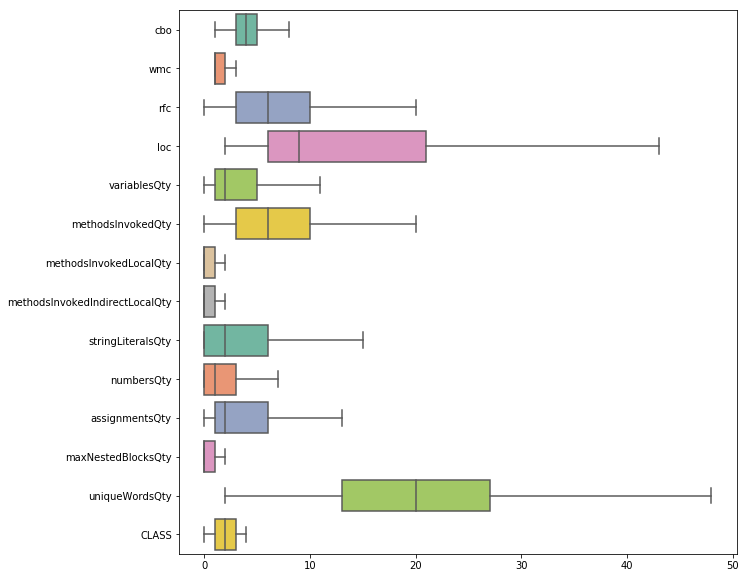

In [6]:
# Aplicando Imputation
imputation()

# Boxplot de todo o dataset
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.boxplot(data=dataset, orient="h", palette="Set2")

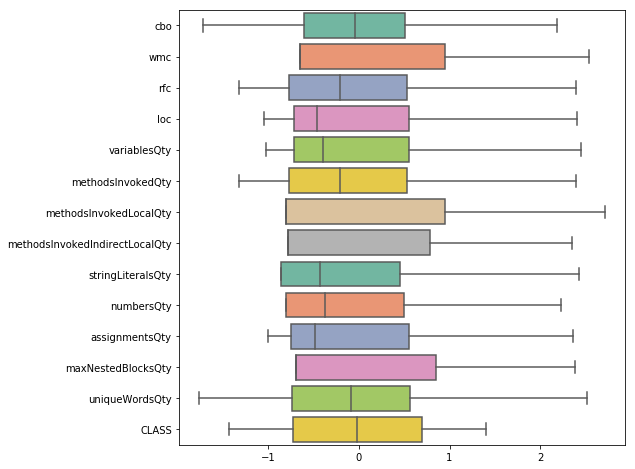

In [115]:
# Normalizando dataset e plotando boxplot novamente
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler().fit(dataset)
scaler = StandardScaler().fit(dataset)
norm_subset = pd.DataFrame(scaler.transform(dataset), columns = dataset.columns)
a = round(norm_subset.describe(), 2)

fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.boxplot(data=norm_subset, orient="h", palette="Set2")

[Text(0.5, 0, 'cbo'),
 Text(1.5, 0, 'wmc'),
 Text(2.5, 0, 'rfc'),
 Text(3.5, 0, 'loc'),
 Text(4.5, 0, 'variablesQty'),
 Text(5.5, 0, 'methodsInvokedQty'),
 Text(6.5, 0, 'methodsInvokedLocalQty'),
 Text(7.5, 0, 'methodsInvokedIndirectLocalQty'),
 Text(8.5, 0, 'stringLiteralsQty'),
 Text(9.5, 0, 'numbersQty'),
 Text(10.5, 0, 'assignmentsQty'),
 Text(11.5, 0, 'maxNestedBlocksQty'),
 Text(12.5, 0, 'uniqueWordsQty'),
 Text(13.5, 0, 'CLASS')]

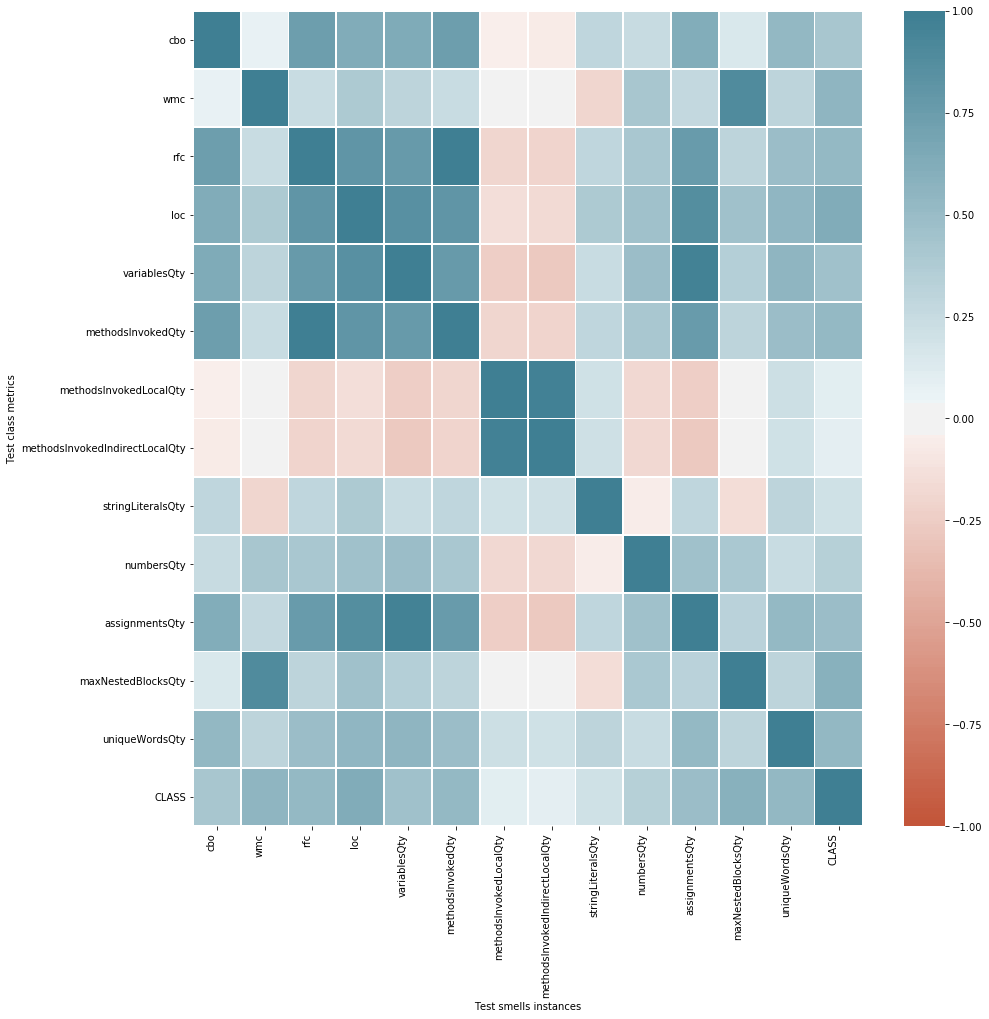

In [116]:
# Só vendo as correlações
#corr = norm_subset.corr(method='spearman').iloc[0:42, 42:]
corr = norm_subset.corr(method='spearman')

fig, ax = plt.subplots(figsize=(15,15))
    
ax = sns.heatmap(
    corr, 
    linewidths=.8,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=False
)
plt.ylabel('Test class metrics')
plt.xlabel('Test smells instances')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)

In [117]:
norm_subset = norm_subset.drop(['methodsInvokedLocalQty'], axis=1)
norm_subset = norm_subset.drop(['variablesQty'], axis=1)
norm_subset = norm_subset.drop(['rfc'], axis=1)

[Text(0.5, 0, 'cbo'),
 Text(1.5, 0, 'wmc'),
 Text(2.5, 0, 'loc'),
 Text(3.5, 0, 'methodsInvokedQty'),
 Text(4.5, 0, 'methodsInvokedIndirectLocalQty'),
 Text(5.5, 0, 'stringLiteralsQty'),
 Text(6.5, 0, 'numbersQty'),
 Text(7.5, 0, 'assignmentsQty'),
 Text(8.5, 0, 'maxNestedBlocksQty'),
 Text(9.5, 0, 'uniqueWordsQty'),
 Text(10.5, 0, 'CLASS')]

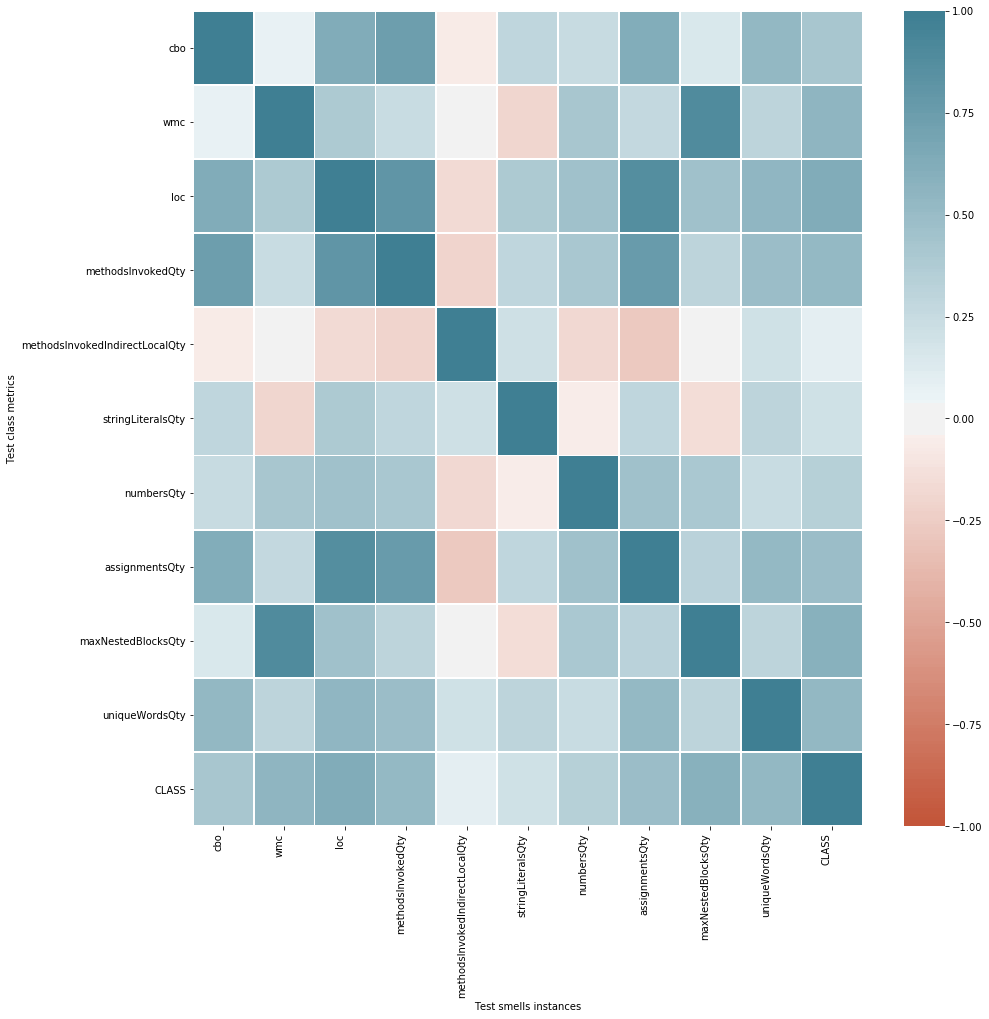

In [118]:
# Só vendo as correlações
#corr = norm_subset.corr(method='spearman').iloc[0:42, 42:]
corr = norm_subset.corr(method='spearman')

fig, ax = plt.subplots(figsize=(15,15))
    
ax = sns.heatmap(
    corr, 
    linewidths=.8,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=False
)
plt.ylabel('Test class metrics')
plt.xlabel('Test smells instances')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)

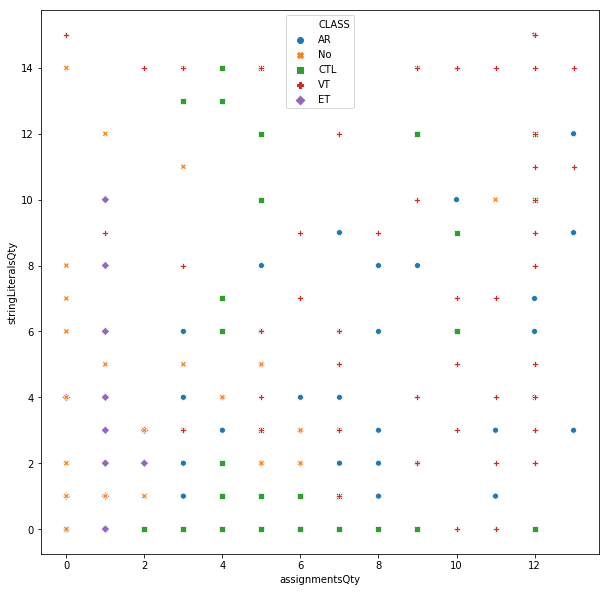

In [120]:
# Distribuição das instâncias considerando as classes
temp = dataset.copy()
temp['CLASS'] = textClassColumn
# Imprimindo o Scatter plot para analisar a distribuição das classes das instâncias
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="assignmentsQty", y="stringLiteralsQty", data=temp, hue="CLASS", style="CLASS", ax=ax)

# Separando dataset para treinamento e teste

In [121]:
# Atualizando classe dos dados normalizados com a classe original
norm_subset["CLASS"] = dataset["CLASS"]

# Dividindo o dataset para treinamento
from sklearn.model_selection import train_test_split
class_column = norm_subset['CLASS']
norm_subset = norm_subset.drop(['CLASS'], axis = 1)
X_train,X_test,y_train,y_test = train_test_split(norm_subset, class_column, test_size=0.2, random_state=70, 
                                                 stratify=class_column, shuffle=True)
print(dataset.shape)
print(X_train.shape)
print(X_test.shape)

(501, 14)
(400, 10)
(101, 10)


# Escolhendo os melhores parâmetros

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

def takeBestParams(classifier, param_grid):
    kfold = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=30)
    #Gridsearch para testar o melhor valor para o parametro
    classifier_gscv = GridSearchCV(classifier, param_grid, cv=kfold, n_jobs=3)
    #Executando teste
    classifier_gscv.fit(X_train, y_train)
    # Imprimindo resultado dos melhores parametros
    return classifier_gscv.best_params_, classifier_gscv.best_score_

## KNN

In [36]:
# Criando um novo modelo KNN
knn = KNeighborsClassifier()
# Dicionario contendo o parametro que queremos testar (utilizando metricas para valores reais)
# Referência para metrica: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric
param_grid = {'n_neighbors': np.arange(2, 25), 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 'p': [1,2]}
takeBestParams(knn, param_grid)

({'metric': 'manhattan', 'n_neighbors': 5, 'p': 1}, 0.8475)

## DWNN

In [53]:
# Criando um novo modelo DWNN
dwnn = KNeighborsClassifier(weights="distance")
# Dicionario contendo o parametro que queremos testar (utilizando metricas para valores reais)
# Referência para metrica: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric
param_grid = {'n_neighbors': np.arange(2, 25), 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 'p': [1,2]}
takeBestParams(dwnn, param_grid)

({'metric': 'manhattan', 'n_neighbors': 5, 'p': 1}, 0.881)

## Logistic Regression

In [27]:
# Criando um novo modelo Logistic Regression
logRegression = LogisticRegression()
# Dicionario contendo o parametro que queremos testar
# Solver: algoritmo a ser usado no problema de otimização
param_grid = {'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'multi_class':['multinomial', 'ovr'], 'random_state': np.arange(0, 50)}
takeBestParams(logRegression, param_grid)

({'multi_class': 'multinomial', 'random_state': 0, 'solver': 'newton-cg'},
 0.8511111111111112)

In [31]:
wlogRegression = LogisticRegression(class_weight="balanced")
param_grid = {'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'multi_class':['multinomial', 'ovr'], 'random_state': np.arange(0, 50)}
takeBestParams(wlogRegression, param_grid)

({'multi_class': 'multinomial', 'random_state': 0, 'solver': 'newton-cg'},
 0.8511111111111112)

## Decision Tree

In [97]:
#Analise sobre o gini vs entropy https://quantdare.com/decision-trees-gini-vs-entropy/ (mais rápido Gini, melhor resultado Entropy)
# Criando um novo modelo DecisionTree
decisionTree = DecisionTreeClassifier()
# Dicionario contendo o parametro que queremos testar
# A poda não foi necessário porque o dataset não é tão grande e não demora muito para encontrar um resultado
param_grid = {'criterion': ['gini', 'entropy'], 'random_state': np.arange(0, 100)}
takeBestParams(decisionTree, param_grid)

exception calling callback for <Future at 0x7f28a361db70 state=finished raised WorkerInterrupt>
Traceback (most recent call last):
  File "/home/levy/.local/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/levy/.local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/levy/.local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/levy/.local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/levy/.local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/levy/.local/lib/python3.5/site-packages/sklearn

KeyboardInterrupt: 

In [ ]:
wdecisionTree = DecisionTreeClassifier(class_weight="balanced")
param_grid = {'criterion': ['gini', 'entropy'], 'random_state': np.arange(0, 100)}
takeBestParams(wdecisionTree, param_grid)

## Random Forest

In [18]:
# Criando um novo modelo RandomForest
randomForest = RandomForestClassifier(n_estimators=100)
# Dicionario contendo o parametro que queremos testar
param_grid = {'criterion': ['gini', 'entropy'], 'random_state': np.arange(0, 100)} # rodar denovo
takeBestParams(randomForest, param_grid)

({'criterion': 'gini', 'random_state': 0}, 0.9111111111111111)

In [27]:
# Criando um novo modelo RandomForest weighted
wrandomForest = RandomForestClassifier(n_estimators=100)
# Dicionario contendo o parametro que queremos testar
param_grid = {'criterion':['gini', 'entropy'], 'class_weight':["balanced_subsample", "balanced"], 'random_state': np.arange(0, 100)}
takeBestParams(wrandomForest, param_grid)

({'class_weight': 'balanced_subsample',
  'criterion': 'gini',
  'random_state': 81},
 0.9133333333333333)

## SVM

In [42]:
# Função de decisão one-vs-one utilizada para multiclass
# https://scikit-learn.org/stable/modules/svm.html
svm = SVC()
# Dicionario contendo o parametro que queremos testar
param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], "decision_function_shape":["ovo", "ovr"], "random_state":np.arange(0, 50)}
takeBestParams(svm, param_grid)

({'decision_function_shape': 'ovo', 'kernel': 'rbf', 'random_state': 0},
 0.8644444444444445)

## Perceptron

In [77]:
perceptron = Perceptron(max_iter=1000)
param_grid = {"tol":[1e-1, 1e-2, 1e-3], "random_state":np.arange(0, 50), "eta0": [0.1, 0.2, 0.3, 0.4, 0.5]}
takeBestParams(perceptron, param_grid)

({'eta0': 0.3, 'random_state': 21, 'tol': 0.1}, 0.8355555555555556)

## MLP

In [86]:
mlp = MLPClassifier(max_iter=100)
param_grid = {"tol":[1e-1, 1e-2, 1e-3], "solver":['lbfgs', 'sgd', 'adam']}
takeBestParams(mlp, param_grid)

/home/levy/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'solver': 'lbfgs', 'tol': 0.01}, 0.8685)

In [87]:
mlp = MLPClassifier(solver='lbfgs', tol=1e-2, max_iter=1000)
param_grid = {"random_state":np.arange(0, 100)}
takeBestParams(mlp, param_grid)

({'random_state': 81}, 0.874)

# Aplicando algoritmos de classificação

In [ ]:
# É melhor o algoritmo errar quando era para não ter test smell e ele disse que tem, do que ter e ele disse que não tem

In [123]:
from sklearn.metrics import confusion_matrix

def verifyModelsScore(estimators):
    results = []
    names = []
    rskfold = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=30)
    skfold = model_selection.StratifiedKFold(n_splits=10, random_state=30)
    minMeaningfulError = None
    maxMeaningfulError = None
    for name, model in estimators:
        y_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skfold)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=rskfold)
        conf_mat = confusion_matrix(y_train, y_pred)
        results.append(cv_results)
        names.append(name)
        print("%s: media %f | DP %f | Max %f" % (name, cv_results.mean(), cv_results.std(), cv_results.max()))
        print("Matriz de confusão")
        print(conf_mat)
        amountOfMeaningfulError = 0
        conf_size = len(conf_mat)
        # Contando os erros significativos para o projeto
        for i in range(conf_size):
            if(i > 0):
                amountOfMeaningfulError += conf_mat[i][0]
        if(not minMeaningfulError):
            minMeaningfulError = (name, amountOfMeaningfulError)
            maxMeaningfulError = (name, amountOfMeaningfulError)
        elif(amountOfMeaningfulError < minMeaningfulError[1]):
            minMeaningfulError = (name, amountOfMeaningfulError)
        elif(amountOfMeaningfulError > maxMeaningfulError[1]):
            maxMeaningfulError = (name, amountOfMeaningfulError)
        print("Erro significativo: ", amountOfMeaningfulError, "\n")
    print("- - -")
    print("Menor erro significativo:", minMeaningfulError[0], ":", minMeaningfulError[1])
    print("Maior erro significativo:", maxMeaningfulError[0], ":", maxMeaningfulError[1])

    return results, names

In [124]:
# Preparando os modelos
estimators = []
model1 = LogisticRegression(multi_class='multinomial', solver="newton-cg", random_state=0)
estimators.append(('LR', model1))
model2 = LogisticRegression(multi_class='multinomial', solver="newton-cg", class_weight="balanced", random_state=0)
estimators.append(('WLR', model2))
model3 = KNeighborsClassifier(n_neighbors = 5, metric="manhattan")
estimators.append(('KNN', model3))
model4 = DecisionTreeClassifier(criterion="entropy", random_state=56)
estimators.append(('TREE', model4))
model5 = DecisionTreeClassifier(criterion="entropy", class_weight="balanced", random_state=57)
estimators.append(('WTREE', model5))
model6 = SVC(decision_function_shape="ovo", kernel="rbf", random_state=0)
estimators.append(('SVM', model6))
model7 = KNeighborsClassifier(n_neighbors = 6, weights="distance", metric="manhattan")
estimators.append(('DWNN', model7))
model8 = Perceptron(tol=1e-2, eta0=0.3, max_iter=1000, random_state=21)
estimators.append(('PERC', model8))
model9 = MLPClassifier(solver='lbfgs', tol=1e-2, max_iter=1000, random_state=81)
estimators.append(('MLP', model9))

# Verificando score de todos so modelos
results, names = verifyModelsScore(estimators)


LR: media 0.820896 | DP 0.042978 | Max 0.926829
Matriz de confusão
[[63  7  6  0  2]
 [ 5 64  1  1  9]
 [ 5  0 73  2  0]
 [ 0  1  0 71  8]
 [ 3 15  0  6 58]]
Erro significativo:  13 

WLR: media 0.822563 | DP 0.042618 | Max 0.926829
Matriz de confusão
[[63  7  6  0  2]
 [ 5 64  1  1  9]
 [ 5  0 73  2  0]
 [ 0  1  0 71  8]
 [ 3 15  0  8 56]]
Erro significativo:  13 

KNN: media 0.860907 | DP 0.047740 | Max 0.948718
Matriz de confusão
[[63 11  3  0  1]
 [ 1 73  2  3  1]
 [ 3  0 77  0  0]
 [ 0  2  0 74  4]
 [ 4 11  1  5 61]]
Erro significativo:  8 

TREE: media 0.865655 | DP 0.053108 | Max 0.950000
Matriz de confusão
[[63  6  1  0  8]
 [ 8 58  3  3  8]
 [ 1  0 79  0  0]
 [ 0  1  1 72  6]
 [ 9  5  0  9 59]]
Erro significativo:  18 

WTREE: media 0.861633 | DP 0.052799 | Max 0.950000
Matriz de confusão
[[63  7  1  0  7]
 [ 7 61  3  2  7]
 [ 1  0 79  0  0]
 [ 0  2  1 72  5]
 [ 8  6  0 10 58]]
Erro significativo:  16 

SVM: media 0.853487 | DP 0.043630 | Max 0.925000
Matriz de confusão
[[63 1

[Text(0, 0, 'LR'),
 Text(0, 0, 'WLR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'TREE'),
 Text(0, 0, 'WTREE'),
 Text(0, 0, 'SVM'),
 Text(0, 0, 'DWNN'),
 Text(0, 0, 'PERC'),
 Text(0, 0, 'MLP')]

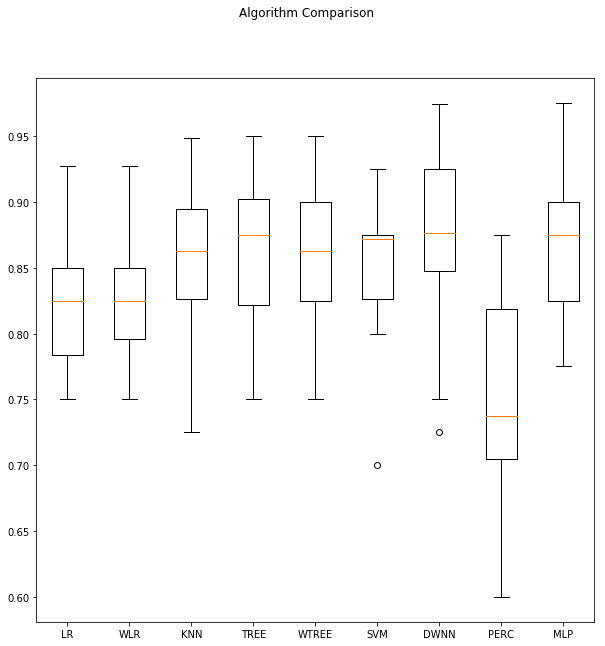

In [125]:
# Plotando boxplot dos resultados
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## Utilizando o melhor dos algoritmos

In [126]:
model7.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')

In [127]:
model7.score(X_test, y_test)

0.8910891089108911

## Ensembles

In [130]:
from sklearn.ensemble import VotingClassifier

ensemblesEstimators = []
ensemblesEstimators.append(('MLP', model9))
model10 = VotingClassifier(estimators[:])
ensemblesEstimators.append(('ALL', model10))
model11 = VotingClassifier(estimators=[('1', model4), ('2', model5), ('3', model6), ('4', model8), ('5', model9)])
ensemblesEstimators.append(('PART', model11))
model12 = RandomForestClassifier(criterion="gini", n_estimators=100, random_state=0)
ensemblesEstimators.append(('RF', model12))
model13 = RandomForestClassifier(class_weight="balanced_subsample", n_estimators=100, criterion="gini", random_state=81)
ensemblesEstimators.append(('WRF', model13))

results, names = verifyModelsScore(ensemblesEstimators)

MLP: media 0.867424 | DP 0.047733 | Max 0.975000
Matriz de confusão
[[66  8  0  0  4]
 [ 5 66  0  2  7]
 [ 0  0 80  0  0]
 [ 0  1  0 71  8]
 [ 7  8  0  4 63]]
Erro significativo:  12 

ALL: media 0.880931 | DP 0.045061 | Max 0.974359
Matriz de confusão
[[67  7  1  0  3]
 [ 4 70  0  3  3]
 [ 3  0 77  0  0]
 [ 0  0  0 75  5]
 [ 5  7  0  6 64]]
Erro significativo:  12 

PART: media 0.891767 | DP 0.047856 | Max 0.975000
Matriz de confusão
[[69  4  1  0  4]
 [ 8 64  0  3  5]
 [ 1  0 79  0  0]
 [ 0  0  0 74  6]
 [ 8  4  0  7 63]]
Erro significativo:  17 

RF: media 0.891061 | DP 0.050236 | Max 0.974359
Matriz de confusão
[[69  7  1  0  1]
 [ 5 68  1  3  3]
 [ 1  0 79  0  0]
 [ 0  2  1 74  3]
 [ 5  7  0  5 65]]
Erro significativo:  11 

WRF: media 0.889374 | DP 0.049620 | Max 0.974359
Matriz de confusão
[[71  5  1  0  1]
 [ 4 68  0  3  5]
 [ 1  0 79  0  0]
 [ 0  2  0 75  3]
 [ 5  8  0  6 63]]
Erro significativo:  10 

- - -
Menor erro significativo: WRF : 10
Maior erro significativo: PART : 1

[Text(0, 0, 'MLP'),
 Text(0, 0, 'ALL'),
 Text(0, 0, 'PART'),
 Text(0, 0, 'RF'),
 Text(0, 0, 'WRF')]

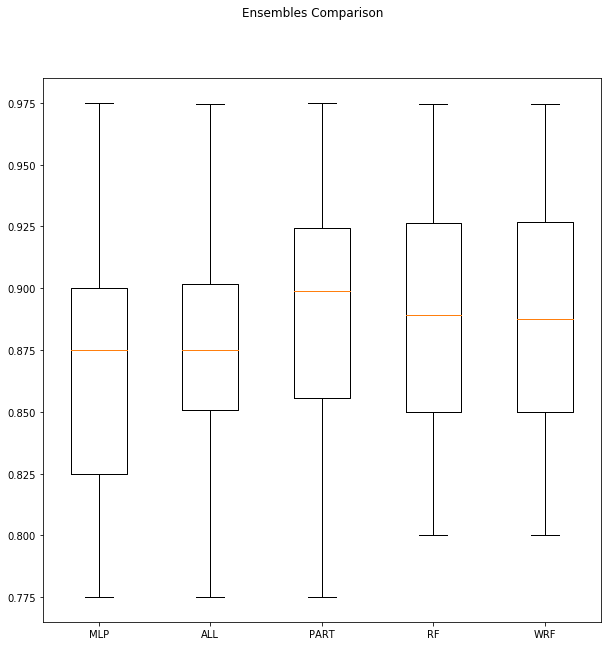

In [131]:
# Plotando boxplot dos resultados
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Ensembles Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

In [107]:
model11.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=81, verbose=0, warm_start=False)

In [108]:
model11.score(X_test, y_test)

0.8811881188118812